In this example, we will use the `gds_fdtd` package to simulate the effect of lithography on a subwavelength-to-strip waveguide mode converter using Lumerical FDTD and demonstrate how fabrication-aware inverse design can be used to optimize the design for a given lithography process.

* Complete tutorial slides can be found in: https://docs.google.com/presentation/d/19zkmcmacTlaXM4p33O1G7T-bS8uGRtZarNtOIAY-I94/edit?usp=sharing

* Reference work: https://opg.optica.org/ol/abstract.cfm?uri=ol-50-1-117


### Lumerical Setup
First, we need to ensure that Lumerical FDTD is installed and that the api 'lumapi' can be imported. 

In [ ]:
import fnmatch
import sys
import os
import platform

mode = None  # Variable for the Lumerical Python API

def find_lumapi():
    # Detect OS and set search path for Lumerical
    system = platform.system()
    if system == 'Darwin':
        path_app = '/Applications'
    elif system == 'Linux':
        path_app = '/opt/'
    elif system == 'Windows':
        path_app = 'C:\\Program Files'
    else:
        raise OSError('Unsupported Operating System.')

    # Search for folders containing "Lumerical" in the expected directory
    lumerical_folders = [s for s in os.listdir(path_app) if "lumerical" in s.lower()]
    
    if not lumerical_folders:
        raise FileNotFoundError(f"No Lumerical installation found in {path_app}.")

    # Check sub-folders for lumapi.py
    search_str = 'lumapi.py'
    for dir_path in lumerical_folders:
        for root, _, filenames in os.walk(os.path.join(path_app, dir_path), followlinks=True):
            if search_str in filenames:
                return os.path.join(root, search_str)

    raise FileNotFoundError("Error: lumapi.py could not be found in the expected directories.")

try:
    lumapi_path = find_lumapi()
    if lumapi_path not in sys.path:
        sys.path.append(os.path.dirname(lumapi_path))

    print(f'Lumerical lumapi.py path: {lumapi_path}')

except Exception as e:
    print(f"Error: {e}")
    sys.exit(1)  # Exit with error

# Current working directory for simulation
dir_path = os.path.dirname(os.getcwd())
print(f'Simulation project path: {dir_path}')

import lumapi


### gds_fdtd Setup
Next, we need to import the necessary modules from the `gds_fdtd` package.

In [30]:
from gds_fdtd.lum_tools import to_lumerical, make_sim_lum
from gds_fdtd.core import parse_yaml_tech
from gds_fdtd.simprocessor import load_component_from_tech
from gds_fdtd.lyprocessor import load_layout

import matplotlib.pyplot as plt
import numpy as np

### Technology and Layout

We now need to import the technology yaml file in which we define the process stack and load the layouts.

In [31]:
tech_path = os.path.join(os.getcwd(), "tech.yaml")  # note materials definition format in yaml
technology = parse_yaml_tech(tech_path)

We will be loading and simulating the layout in the `gds` directory which contain three examples:
1. A subwavelength-to-strip waveguide mode converter optimized using inverse design.
2. A subwavelength-to-strip waveguide mode converter optimized using inverse design after lithography.
3. A subwavelength-to-strip waveguide mode converter optimized using fabrication-aware inverse design after lithography.

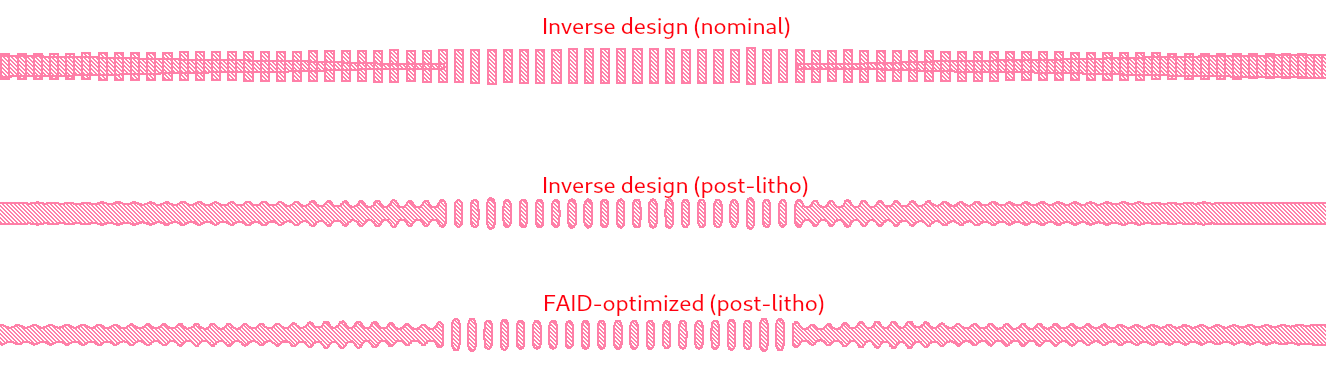



In [32]:
fpath_swg_nominal = os.path.join(os.getcwd(), "gds", "SWG_nominal.gds")
fpath_swg_nominal_litho = os.path.join(os.getcwd(), "gds", "SWG_nominal_postduv.gds")
fpath_swg_faid_litho = os.path.join(os.getcwd(), "gds", "SWG_faid_postduv.gds")

### Executing FDTD Simulation

We first load the layout and convert it to a component and run the simulation to extract the S-parameters.

For case 1: Nominal subwavelength-to-strip waveguide mode converter optimized using inverse design.


In [33]:
import lumapi

layout = load_layout(fpath_swg_nominal)
component = load_component_from_tech(ly=layout, tech=technology)

fdtd = lumapi.FDTD()  # can also be mode/device

to_lumerical(c=component, lum=fdtd)

sparams_swg_nominal = make_sim_lum(
    c=component,
    lum=fdtd,
    wavl_min=1.5,
    wavl_max=1.6,
    wavl_pts=101,
    width_ports=3.0,
    depth_ports=2.0,
    symmetry=(0, 0, 0),
    pol="TE",
    num_modes=1,
    boundary="pml",
    mesh=3,
    run_time_factor=50,
    visualize=False
)


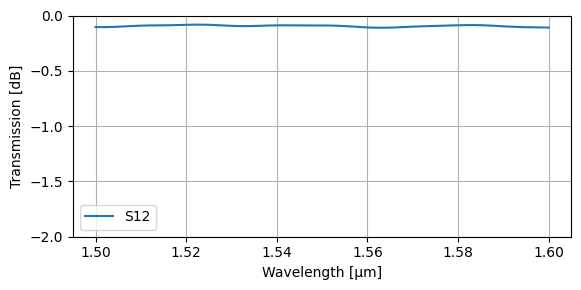

In [34]:

plt.figure(figsize=(6, 3))

plt.plot(1e6*np.array(sparams_swg_nominal["wavl"]), 10*np.log10(np.abs(sparams_swg_nominal["s1_2"])**2), label=f"S12")

plt.ylabel("Transmission [dB]")
plt.xlabel("Wavelength [μm]")
plt.grid(True)
plt.ylim(-2, 0)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [35]:
import lumapi

layout = load_layout(fpath_swg_nominal_litho)
component = load_component_from_tech(ly=layout, tech=technology)

fdtd = lumapi.FDTD()  # can also be mode/device

to_lumerical(c=component, lum=fdtd)

sparams_swg_nominal_litho = make_sim_lum(
    c=component,
    lum=fdtd,
    wavl_min=1.5,
    wavl_max=1.6,
    wavl_pts=101,
    width_ports=3.0,
    depth_ports=2.0,
    symmetry=(0, 0, 0),
    pol="TE",
    num_modes=1,
    boundary="pml",
    mesh=3,
    run_time_factor=50,
    visualize=False
)


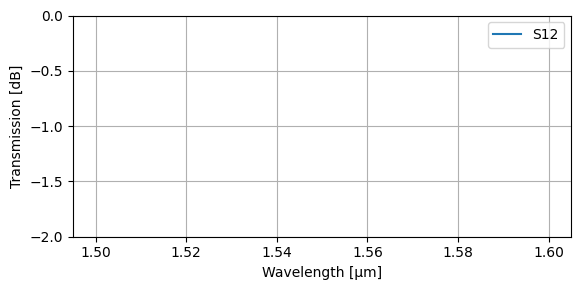

In [36]:

plt.figure(figsize=(6, 3))

plt.plot(1e6*np.array(sparams_swg_nominal_litho["wavl"]), 10*np.log10(np.abs(sparams_swg_nominal_litho["s1_2"])**2), label=f"S12")

plt.ylabel("Transmission [dB]")
plt.xlabel("Wavelength [μm]")
plt.grid(True)
plt.ylim(-2, 0)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [37]:
import lumapi

layout = load_layout(fpath_swg_faid_litho)
component = load_component_from_tech(ly=layout, tech=technology)

fdtd = lumapi.FDTD()  # can also be mode/device

to_lumerical(c=component, lum=fdtd)

sparams_swg_faid_litho = make_sim_lum(
    c=component,
    lum=fdtd,
    wavl_min=1.5,
    wavl_max=1.6,
    wavl_pts=101,
    width_ports=3.0,
    depth_ports=2.0,
    symmetry=(0, 0, 0),
    pol="TE",
    num_modes=1,
    boundary="pml",
    mesh=3,
    run_time_factor=50,
    visualize=False
)


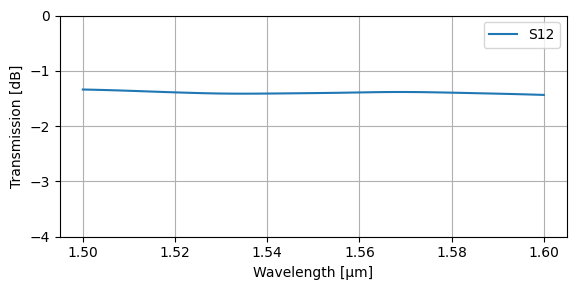

In [38]:

plt.figure(figsize=(6, 3))

plt.plot(1e6*np.array(sparams_swg_faid_litho["wavl"]), 10*np.log10(np.abs(sparams_swg_faid_litho["s1_2"])**2), label=f"S12")

plt.ylabel("Transmission [dB]")
plt.xlabel("Wavelength [μm]")
plt.grid(True)
plt.ylim(-4, 0)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

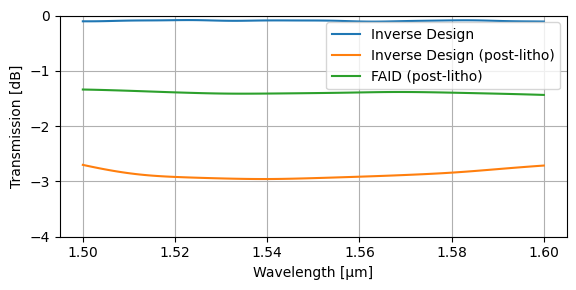

In [39]:

plt.figure(figsize=(6, 3))

plt.plot(1e6*np.array(sparams_swg_nominal["wavl"]), 10*np.log10(np.abs(sparams_swg_nominal["s1_2"])**2), label=f"Inverse Design")
plt.plot(1e6*np.array(sparams_swg_nominal_litho["wavl"]), 10*np.log10(np.abs(sparams_swg_nominal_litho["s1_2"])**2), label=f"Inverse Design (post-litho)")
plt.plot(1e6*np.array(sparams_swg_faid_litho["wavl"]), 10*np.log10(np.abs(sparams_swg_faid_litho["s1_2"])**2), label=f"FAID (post-litho)")


plt.ylabel("Transmission [dB]")
plt.xlabel("Wavelength [μm]")
plt.grid(True)
plt.ylim(-4, 0)
plt.legend(loc="best")
plt.tight_layout()
plt.show()